In [1]:
import os, glob
import datetime as dt
import sqlite3
import pandas as pd
import numpy as np
os.chdir('/mnt/499f5b4c-132a-4775-a414-ce6eba504896/lending/')
files = glob.glob('*')
files

['lending-club-loan-data.zip',
 'loan.csv',
 'LCDataDictionary.xlsx',
 'database.sqlite']

In [2]:
conn = sqlite3.connect('database.sqlite')
c = conn.cursor()
c.execute("select name from sqlite_master where type = 'table'")
c.fetchall()

[('loan',)]

In [3]:
data = pd.read_sql_query("select * from loan", conn)

In [4]:
data = data[(data['issue_d'].notnull()) & (data['loan_status'].notnull())]
data = data[(data['last_pymnt_d'].notnull() | (data['loan_status']!='Fully Paid'))]

### clean date fields
from dateutil.parser import parse
def dateParser(x):
    try:
        return parse(x).date()
    except:
        return x
data['issue_d'] = data['issue_d'].apply(lambda x: dateParser(x))
### assessing what "present" is in this dataset.  I'll assume Jan 1 2016 is the current date
data['last_pymnt_d'] = data['last_pymnt_d'].apply(lambda x: dateParser(x))
data['last_pymnt_d'].dropna().max()

datetime.date(2016, 1, 16)

In [5]:
### Used the net annualized return formula found on Lending Club's website
### https://www.lendingclub.com/public/lendersPerformanceHelpPop.action
### I threw out the 1% service charge for yield calculations 

netAnnualizedReturn = []

today = dt.date(2016, 1, 1)

# calculate net annualized return for each loan (row-wise)
for index, row in data.iterrows():
    inv_return = row['total_rec_int'] + row['total_rec_late_fee']
    loss = 0

    # specify loan period based on the current loan status
    if row['loan_status'] == 'Fully Paid':
        duration = (row['last_pymnt_d'] - row['issue_d']).days/30
    elif any(check in row['loan_status'].lower() for check in ['charged off', 'default']):
        loss = row['funded_amnt_inv'] - row['total_rec_prncp'] - row['recoveries'] + row['collection_recovery_fee']
        try:
            active = (row['last_pymnt_d'] - row['issue_d']).days/30
            toDate = (today-row['issue_d']).days/30 -1
            # charge off occurs within 6 months   
            duration = min(active+6, toDate)
        except:
            # if there is no last_pymnt_d, charge off will occur at 6 months from origination
            duration = 6
    else:
        duration = (today-row['issue_d']).days/30 - 1

    duration = int(duration)
    # if the loan is paid off in a month
    if duration == 0:
        t = 12
    else:
        t=12/duration

    #calculate compounded return
    compoundedReturn = (1 + (inv_return-loss) / row['funded_amnt'])**t - 1 
    netAnnualizedReturn.append(compoundedReturn)

In [6]:
data['netAnnualizedReturn'] =  netAnnualizedReturn
data = data[data['netAnnualizedReturn'].notnull()]

In [7]:
import matplotlib.pyplot as plt
plt.hist(data['netAnnualizedReturn'],color='salmon', bins=24, range=(-1,1), label='simple_nar')
plt.xlabel('return')
plt.ylabel('frequency')
plt.grid()
plt.show()

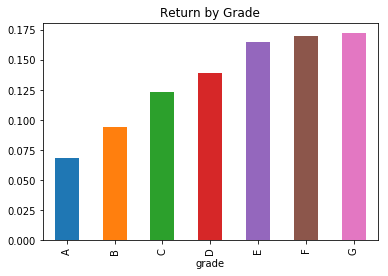

In [8]:
grade_group = data.groupby('grade')
grade_group.mean()['netAnnualizedReturn'].plot(kind='bar')
plt.title('Return by Grade')
plt.show()

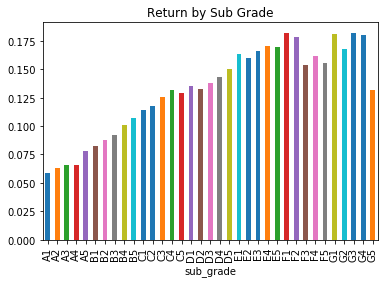

In [9]:
grade_group = data.groupby('sub_grade')
grade_group.mean()['netAnnualizedReturn'].plot(kind='bar')
plt.title('Return by Sub Grade')
plt.show()

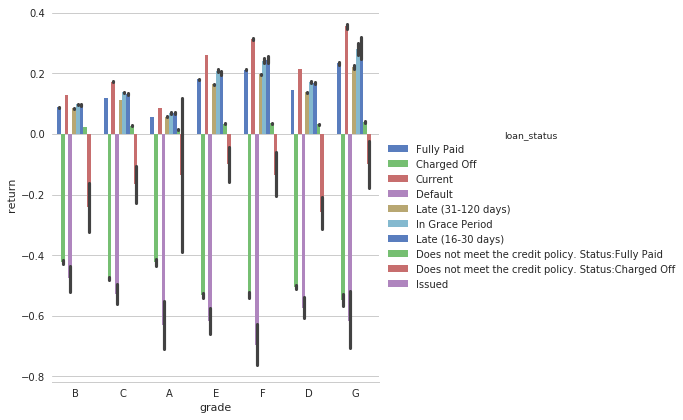

In [10]:
import seaborn as sns
###  Here we see the risk vs reward relationship found in loan grade.  The higher the letter grade, the higher the return 
### tends to be on loans that get paid off, but the average losses get greater as well if the loan gets charged off
sns.set(style="whitegrid")

g = sns.factorplot(x="grade", y="netAnnualizedReturn", hue="loan_status", data=data,
                   size=6, kind="bar", palette="muted")

g.despine(left=True)
g.set_ylabels("return")

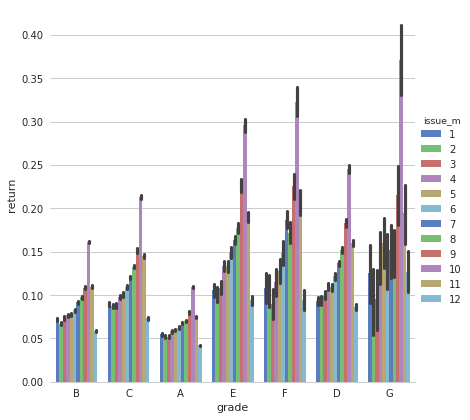

In [11]:
### interestingly, there is a relationship between month of issuance and return.  Returns increase from December
### throughout the years and peak in October.  This relationship becomes less reliable in G grade loans
data['issue_m'] = data['issue_d'].apply(lambda x: int(x.month))
sns.set(style="whitegrid")

g = sns.factorplot(x="grade", y="netAnnualizedReturn", hue="issue_m", data=data,
                   size=6, kind="bar", palette="muted")

g.despine(left=True)
g.set_ylabels("return")

In [12]:
data.groupby(['issue_m']).mean()['netAnnualizedReturn']

issue_m
1     0.080877
2     0.077928
3     0.081525
4     0.091250
5     0.092930
6     0.101451
7     0.113012
8     0.120620
9     0.140521
10    0.194300
11    0.129394
12    0.067444
Name: netAnnualizedReturn, dtype: float64

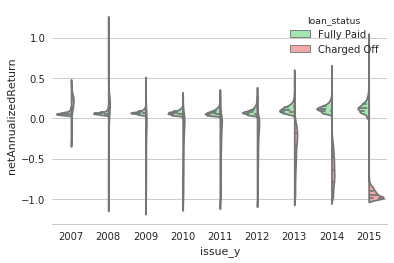

In [14]:
### Here we see the time it takes to recoup losses after a charge off. Returns of paid loans are consistent through time, 
### but the distribution of losses spread out closer to 0 from 100% the more time has passed since default
data['issue_y'] = data['issue_d'].apply(lambda x: str(x.year))
sns.set(style="whitegrid", palette="pastel", color_codes=True)

sns.violinplot(x="issue_y", y="netAnnualizedReturn", hue="loan_status", data=data[data.loan_status.isin(
    ['Charged Off', 'Fully Paid'])], split=True,
               inner="quart", palette={"Fully Paid": "g", "Charged Off": "r"})
sns.despine(left=True)

In [15]:
data.groupby(['loan_status', 'issue_y']).mean()['netAnnualizedReturn']

loan_status                                          issue_y
Charged Off                                          2007       0.169573
                                                     2008       0.093623
                                                     2009      -0.306855
                                                     2010      -0.315969
                                                     2011      -0.340724
                                                     2012      -0.338431
                                                     2013      -0.397883
                                                     2014      -0.632964
                                                     2015      -0.936196
Current                                              2010       0.066495
                                                     2011       0.081871
                                                     2012       0.115066
                                                     2013      

In [16]:
today = dt.date(2016,1,1)
def loanTimer(x):
    try:
        if (today - x).days >= (36*30):
            return 1
        else:
            return 0
    except:
        return x

data['over36Months'] = data['issue_d'].apply(lambda x: loanTimer(x))
data['over36Months'].describe()
### remove loans that have not aged out at least 36 months
data = data[data.over36Months == 1].reset_index(drop  = True)

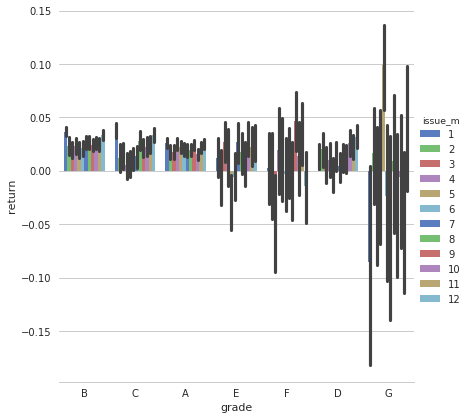

In [17]:
### Going back to my earlier monthly return plots, I see that it was biased by including young loans 
data['issue_m'] = data['issue_d'].apply(lambda x: int(x.month))
sns.set(style="whitegrid")

g = sns.factorplot(x="grade", y="netAnnualizedReturn", hue="issue_m", data=data,
                   size=6, kind="bar", palette="muted")

g.despine(left=True)
g.set_ylabels("return")

In [18]:
### average return across all samples is 2.12%
data['netAnnualizedReturn'].mean()

0.021235530514569584

In [19]:
### Here we see a very disjointed trend when assessing return by year.  The high return in 2007/08 I suspect is due to the 
### the fact that there has been enough time to recoup losses in defaulted loans
data.groupby(['issue_y']).mean()['netAnnualizedReturn']

issue_y
2007    0.063288
2008    0.051863
2009    0.016058
2010    0.012929
2011    0.013890
2012    0.022613
2013    0.038531
Name: netAnnualizedReturn, dtype: float64

In [20]:
### The relatively low overall return surprised me in the face of much higher yearly averages.  It appears the data is 
### biased towards 2011/12 due to the high volume of loans in those years
data.groupby(['issue_y']).count()['id']

issue_y
2007      603
2008     2393
2009     5281
2010    12537
2011    21721
2012    53367
2013     6872
Name: id, dtype: int64

In [21]:
### The pertinent simplifying assumption made in the above analysis really hinges around only considering defaulted or 
### charged off loans as lost revenue.  In actuality, we should be negatively weighting late loans as well, or we could  
### just look at the fully paid vs charged off loans, as they represent the only data points we can be sure of in terms  
### of final return (excepting the above point on charged off losses being slightly negated through time).  However, we 
### would be throwing a lot of data by doing that, so I passed over it.

In [22]:
### clean home_ownership
def homeParser(x):
    try:
        val = 0
        if any(check in x.lower() for check in ['own', 'mortgage']):
            val = 1
        return val
    except:
        return x
data['home_ownership'] = data['home_ownership'].apply(lambda x: homeParser(x))
### clean verification_status
def verificationParser(x):
    try:
        if 'not' in x.lower():
            return 0
        else:
            return 1 
    except:
        return x
data['verification_status'] = data['verification_status'].apply(lambda x: verificationParser(x))
### simplified employment.  0 if no valid data
def empParser(x):
    try:
        if x == '10+ years':
            return 10
        else:
            return int(x.split(' ')[0])
    except:
        return 0
data['emp_length'] = data['emp_length'].apply(lambda x: empParser(x))
def percentageParser(x):
    try:
        return float(x.replace('%', ''))
    except:
        return x
data['int_rate'] = data['int_rate'].apply(lambda x: percentageParser(x))
data['revol_util'] = data['revol_util'].apply(lambda x: percentageParser(x))

In [47]:
# ### made a list of linear variables that would be available at time of issuance for new loans 
potentialVariables = """open_acc_6m
home_ownership
verification_status
open_il_6m
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
inq_fi
total_cu_tl
inq_last_12m
acc_now_delinq
tot_coll_amt
tot_cur_bal
total_acc
revol_bal
revol_util
pub_rec
open_acc
mths_since_last_delinq
mths_since_last_major_derog
loan_amnt
int_rate
installment
home_ownership
funded_amnt_inv
emp_length
dti
dti_joint
collections_12_mths_ex_med
delinq_2yrs
annual_inc"""
potentialVariables = potentialVariables.split('\n')

In [49]:
### making sure all fields are cleaned and mean deviated 
for i in potentialVariables:
    print(i)
    data[i] = data[i].astype(float)
    data[i + '_deviated'] = (data[i] - data[i].mean()) / data[i].std()

open_acc_6m
home_ownership
verification_status
open_il_6m
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
inq_fi
total_cu_tl
inq_last_12m
acc_now_delinq
tot_coll_amt
tot_cur_bal
total_acc
revol_bal
revol_util
pub_rec
open_acc
mths_since_last_delinq
mths_since_last_major_derog
loan_amnt
int_rate
installment
home_ownership
funded_amnt_inv
emp_length
dti
dti_joint
collections_12_mths_ex_med
delinq_2yrs
annual_inc


In [53]:
### first, I want to look at the quality of each field.  Specifically, any field with > 10% missing data, I assume
### is a poor source of information for a first pass at training a model
descriptions = data.describe()
blank = []
for i in descriptions.columns:
    blank.append([i, descriptions[i]['count'] / len(data)])
portion = pd.DataFrame(blank).sort_values(1)
for i in portion[portion[1] < .9][0].unique():
    data = data.drop(i, axis = 1)

In [54]:
potentialVariables = [x for x in potentialVariables if x in data.columns]

In [55]:
### ExtraTreesClassifier used to determine variable importance on whether a loan defaults.  Quick and easy way to pull 
### out important variables for modeling 

### clean loan status.  Will be using this metric as a binary outcome to optimize towards
data['loan_status'].unique()
def loanCleaner(x):
    val = 0
    if any(check in x.lower() for check in ['paid', 'current', 'grace']):
        val = 1
    elif any(check in x.lower() for check in ['grace', 'issued']):
        val = -1
    return val
data['loan_standing'] = data['loan_status'].apply(lambda x: loanCleaner(x))
data = data[data.loan_standing >= 0]

### remove rows with any missing data we are about to test
potentialVariables = [x for x in data.columns if '_deviated' in x]
potentialVariables.append('loan_standing')

In [56]:
temp = data[potentialVariables].dropna()
target = temp[['loan_standing']]
temp = temp.drop('loan_standing', axis = 1)
potentialVariables = [x for x in potentialVariables if x != 'loan_standing']

Feature ranking:
int_rate_deviated
1. feature 9 (0.110140)
revol_util_deviated
2. feature 5 (0.090754)
dti_deviated
3. feature 13 (0.089888)
annual_inc_deviated
4. feature 16 (0.089664)
revol_bal_deviated
5. feature 4 (0.089281)
total_acc_deviated
6. feature 3 (0.085139)
installment_deviated
7. feature 10 (0.084568)
funded_amnt_inv_deviated
8. feature 11 (0.081538)
open_acc_deviated
9. feature 7 (0.081531)
loan_amnt_deviated
10. feature 8 (0.074737)
emp_length_deviated
11. feature 12 (0.066541)
delinq_2yrs_deviated
12. feature 15 (0.026540)
pub_rec_deviated
13. feature 6 (0.011374)
home_ownership_deviated
14. feature 0 (0.008979)
verification_status_deviated
15. feature 1 (0.008943)
collections_12_mths_ex_med_deviated
16. feature 14 (0.000195)
acc_now_delinq_deviated
17. feature 2 (0.000188)


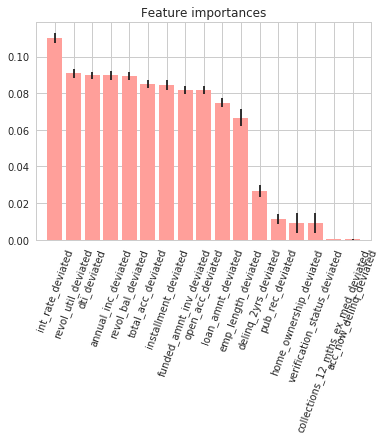

In [57]:
### rough assessment of field importance on defaulting 
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=100,
                              random_state=1)

forest.fit(temp[potentialVariables], target['loan_standing'])
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]
realNames = []
for i in indices:
    realNames.append(temp[potentialVariables].columns[i])
print("Feature ranking:")
weights = {}
for f in range(temp[potentialVariables].shape[1]):
    print(potentialVariables[indices[f]])
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    weights[potentialVariables[indices[f]]] = importances[indices[f]]
    plt.figure()
plt.title("Feature importances")
plt.bar(range(temp[potentialVariables].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(temp[potentialVariables].shape[1]), realNames, rotation=70)
plt.xlim([-1, temp[potentialVariables].shape[1]])
plt.show()

In [85]:
strongVariables = []
for i in weights.keys():
    if weights[i] > .05:
        strongVariables.append(i)

In [86]:
strongVariables_ = strongVariables.copy()
strongVariables_.append('netAnnualizedReturn')
strongVariables_.append('id')

In [87]:
strongVariables_

['int_rate_deviated',
 'revol_util_deviated',
 'dti_deviated',
 'annual_inc_deviated',
 'revol_bal_deviated',
 'total_acc_deviated',
 'installment_deviated',
 'funded_amnt_inv_deviated',
 'open_acc_deviated',
 'loan_amnt_deviated',
 'emp_length_deviated',
 'netAnnualizedReturn',
 'id']

In [89]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

toTest = data[strongVariables_].dropna()
# Split the data into training/testing sets
data_train = toTest.sample(frac=0.7)
data_test = toTest[~toTest.id.isin(data_train.id.unique())]

target_train = data_train['netAnnualizedReturn']
target_test = data_test['netAnnualizedReturn']

regr = linear_model.LinearRegression()

regr.fit(data_train[strongVariables], target_train)

data_y_pred = regr.predict(data_test[strongVariables])

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(target_test, data_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(target_test, data_y_pred))

Coefficients: 
 [-0.00511921  0.00355919 -0.00355547  0.01061842 -0.00402471  0.00456758
  0.01471958 -0.0180459   0.00112091  0.00718197  0.00092534]
Mean squared error: 0.04
Variance score: 0.00


In [90]:
toPlot = pd.DataFrame(target_test)
toPlot['predicted'] = data_y_pred
toPlot = toPlot.sort_values('netAnnualizedReturn').reset_index(drop = True)

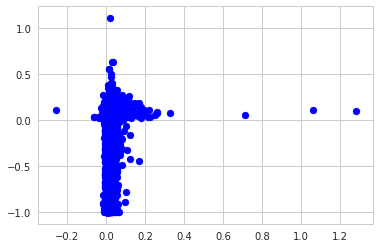

In [102]:
# Plot outputs
plt.scatter(toPlot['predicted'], toPlot['netAnnualizedReturn'], color='blue')
plt.show()

In [101]:
toPlot['predicted'].describe()
### this model is trash.  It's predicting 50% of the data between a return of 1.2% and 2.8%. It's pretty much 
### predicting the mean for most loans

count    30791.000000
mean         0.021939
std          0.017750
min         -0.257139
25%          0.012588
50%          0.019948
75%          0.028665
max          1.282943
Name: predicted, dtype: float64

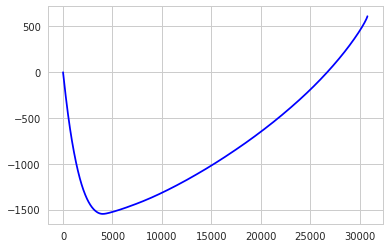

In [99]:
### looking at the spread of returns, it looks like our losses are concentrated to a relatively small portion of the 
### total loans.  While return is a linear variable, I'm thinking we can reframe the problem as a issue of classification.
### If we can build a model that instead outputs a probability of defaulting, we can cut out a lot of our losses without
### trying to project actual return 
toPlot['cummulative'] = toPlot['netAnnualizedReturn'].cumsum()
plt.plot(toPlot['cummulative'], color='blue')
plt.show()